# Experimento 7 : DEM. Data Extraction Module.

En este experimiento se pretende crear un módulo no entrenable que extraiga información a través de la segmentación de la lesión.

## Librerías usadas.

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

## Parámetros globales

In [19]:
#Rutas de los datos.
 
data_dir = os.path.dirname(os.path.realpath("../TFG/Datos/HAM10000_metadata.csv"))
checkpoints = os.path.dirname(os.path.realpath("../TFG/Pix2PixCheckpoints/..."))


csv_path = os.path.realpath(data_dir + "/HAM10000_metadata.csv")

#Variables globales

altura = 64
longitud = 64
clases = 7


print(data_dir)

print(csv_path)



/home/antgarnie/Escritorio/TFG/Datos
/home/antgarnie/Escritorio/TFG/Datos/HAM10000_metadata.csv


In [20]:
 
data_dir_mascara_binaria = os.path.dirname(os.path.realpath("../TFG/DatosMascaraBinaria2/HAM10000_segmentations/..."))
data_dir_mascara_superpuesta = os.path.dirname(os.path.realpath("../TFG/DatosMascaraSuperpuesta/..."))
print(data_dir_mascara_binaria +"    "+ data_dir_mascara_superpuesta)

/home/antgarnie/Escritorio/TFG/DatosMascaraBinaria2/HAM10000_segmentations    /home/antgarnie/Escritorio/TFG/DatosMascaraSuperpuesta


## Creación del marco de datos.

In [21]:
def combineData(data_dir):
    all_image_path = glob(os.path.join(data_dir, '*', '*'))
    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
    return imageid_path_dict

def combineData_1(data_dir):
    all_image_path = glob(os.path.join(data_dir, '*'))
    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
    return imageid_path_dict




#Inicializando el dataFrame

dataFrame=pd.read_csv(csv_path)

#Mezclando carpetas.

data_dict = combineData(data_dir)
data_dict_mask = combineData_1(data_dir_mascara_binaria)

def rename_keys(d, keys):
    return dict([(keys.get(k,k), v) for k, v in d.items()])

keys_values_transformer = {}
for element in data_dict_mask.keys():
    element_trans = element.replace("_segmentation","")
    keys_values_transformer[element]  = element_trans
    


data_dict_mask = rename_keys(data_dict_mask, keys_values_transformer)


data_dict_rgb_mask = combineData(data_dir_mascara_superpuesta)

# Inicializando diccionario de categorías

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Añadiendo columnas al dataFrame para que sea más legible.

dataFrame['path'] = dataFrame['image_id'].map(data_dict.get)
dataFrame['mask_path'] = dataFrame['image_id'].map(data_dict_mask.get)
dataFrame['rgb_mask_path'] = dataFrame['image_id'].map(data_dict_rgb_mask.get)

dataFrame = dataFrame.drop('dx', 1)
dataFrame = dataFrame.drop('dx_type', 1)
dataFrame = dataFrame.drop('age', 1)
dataFrame = dataFrame.drop('sex', 1)
dataFrame = dataFrame.drop('localization', 1)

dataFrame.head()


,lesion_id,image_id,path,mask_path,rgb_mask_path
0,HAM_0000118,ISIC_0027419,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,/home/antgarnie/Escritorio/TFG/DatosMascaraBin...,/home/antgarnie/Escritorio/TFG/DatosMascaraSup...
1,HAM_0000118,ISIC_0025030,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,/home/antgarnie/Escritorio/TFG/DatosMascaraBin...,/home/antgarnie/Escritorio/TFG/DatosMascaraSup...
2,HAM_0002730,ISIC_0026769,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,/home/antgarnie/Escritorio/TFG/DatosMascaraBin...,/home/antgarnie/Escritorio/TFG/DatosMascaraSup...
3,HAM_0002730,ISIC_0025661,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,/home/antgarnie/Escritorio/TFG/DatosMascaraBin...,/home/antgarnie/Escritorio/TFG/DatosMascaraSup...
4,HAM_0001466,ISIC_0031633,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,/home/antgarnie/Escritorio/TFG/DatosMascaraBin...,/home/antgarnie/Escritorio/TFG/DatosMascaraSup...


In [22]:
def prepro(l):
    nl = []
    for i in tqdm(range(len(l))):
        splits = randurls[i].split("/")
        fileN = splits[-2]+"/"+splits[-1]
        nl.append(fileN)
    return nl

n = 500                         #Número de muestras a tomar
train_n = round(n*0.80)         #Separación de set de datos y entrenamiento
imgurls = dataFrame['path']
randurls = np.copy(imgurls)

np.random.seed(23)              #Sirve para que la aleatoriedad seaa siempre la misma
np.random.shuffle(randurls)
randurls = prepro(randurls)
#Partición train/test
tr_urls = randurls[:train_n]
ts_urls =randurls[train_n:n]

print(len(imgurls), len(tr_urls),len(ts_urls))

100%|██████████| 10015/10015 [00:00<00:00, 710123.82it/s]

10015 400 100


################################################
Center        ->  (64.5, 55.59)
Area          ->  1258.0
Radius        ->  27
Correlation   ->  0.7475994423559037
################################################


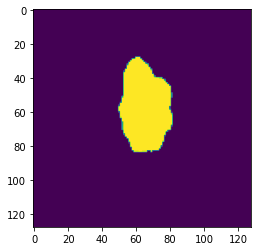

In [27]:
def extract_info_from_an_image(img):

    contours,hierarchy = cv2.findContours(img,2,1)
    cnts = max(contours, key=cv2.contourArea)
    ca = cv2.contourArea(cnts)
    (x,y),radius = cv2.minEnclosingCircle(cnts)
    radius = int(radius)
    center = (round(x,2),round(y,2))
    
    return center,ca,radius

def calculate_corcoef(img,out):
    rows = []
    columns = []
    
    for row in img: rows.append(sum(row))    
    for col in out: columns.append(sum(col))

    correlation_coeficient = np.corrcoef(rows,columns)[0][1]
    return correlation_coeficient

def norm_data(image_path,new_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img,new_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    def rotate_90_degrees(img):
        out=cv2.transpose(img)
        out=cv2.flip(out,flipCode=1)
        return out
    
    rotated_image = rotate_90_degrees(img)
    
    return img,rotated_image

def data_extractor_module(image_path,new_size,to_string=True):
    img,rotated_image = norm_data(image_path,new_size)
    center,ca,radius  = extract_info_from_an_image(img)
    correlation_coeficient = calculate_corcoef(img,rotated_image)
    if to_string:
        print("################################################")
        print("Center        ->  " + str(center))
        print("Area          ->  " + str(ca))
        print("Radius        ->  " + str(radius))
        print("Correlation   ->  " + str(correlation_coeficient))
        print("################################################")
    
    return center,ca,radius,correlation_coeficient

image_index = 3
center,ca,radius,correlation_coeficient = data_extractor_module(dataFrame['mask_path'][image_index],
                                                                (128,128),
                                                                to_string=True)   




image,rot_img = norm_data(dataFrame['mask_path'][image_index],(128,128))
plt.imshow(image)
plt.show()